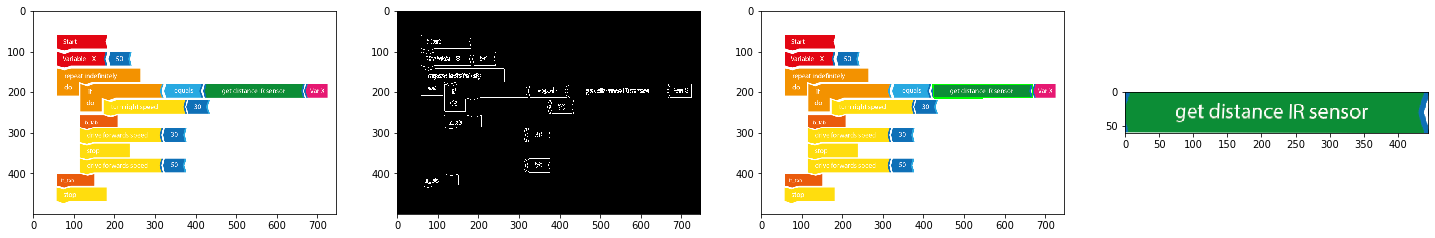

In [1]:
import numpy as np
import cv2 as cv
import imutils
import matplotlib.pyplot as plt
from PIL import Image

image = cv.imread('test_images/example.PNG')
ratio = image.shape[0] / 500.0
orig = image.copy()
image = imutils.resize(image, height = 500)

gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
gray = cv.GaussianBlur(gray, (3, 3), 0)
edged = cv.Canny(gray, 75, 200)

cnts = cv.findContours(edged.copy(), cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv.contourArea, reverse = True)[:5]
for c in cnts:
	peri = cv.arcLength(c, True)
	approx = cv.approxPolyDP(c, 0.02 * peri, True)
	if len(approx) == 4:
		screenCnt = approx
		break

result = cv.drawContours(image.copy(), [screenCnt], -1, (0, 255, 0), 2)

def order_points(pts):
	rect = np.zeros((4, 2), dtype = "float32")
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	return rect

def four_point_transform(image, pts):
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	M = cv.getPerspectiveTransform(rect, dst)
	warped = cv.warpPerspective(image, M, (maxWidth, maxHeight))
	return warped

warped = four_point_transform(orig, screenCnt.reshape(4,2)* ratio)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(25,10))
ax1.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
ax2.imshow(edged, cmap='gray')
ax3.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
ax4.imshow(cv.cvtColor(warped, cv.COLOR_BGR2RGB))
plt.show()